In [1]:
import itertools
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import local

In [2]:
DATA = local.Data151v()

# Muut osakkeet

Tilaston dokumentaatiossa kerrotaan tästä erästä seuraavaa:

> **Noteeraamattomien osakkeiden** arvo eli listaamattoman osakeyhtiön laskennallinen nettovarallisuus on muodostettu henkilöveroaineistosta osinkoa maksaneiden listaamattomien yhtiöiden nettovarallisuutena, joka määräytyy yhtiön edellisenä vuonna päättyneen tilikauden taseen perusteella. Noteeraamattomat osakkeet ovat tiedossa vain niille henkilöille, jotka ovat saaneet osinkoja listaamattomista yhtiöistä. Noteeraamattomien osakkeiden arvo ei ole vertailukelpoinen vuosien 1987–2004 ja 2009–2023 välillä, sillä vanhemmat tiedot perustuvat haastattelutietoihin ja ne olivat nimellisarvoja.

Todennäköisesti tästä johtuu vuosien 2004 ja 2009 välillä tapahtunut harppaus, jossa tämän varallisuuslajin arvo D10:ssä yli nelinkertaistui.

In [3]:
def plot_laji(ax, laji):
    nimi = DATA.table.label_varallisuuslaji(laji)
    title = f"Varallisuuslajin \"{nimi}\" keskiarvo kotitalouksissa (nimellisissä euroissa)"
    local.plot.laji(ax, DATA, laji, DATA.ftotaln(), "miljardia euroa", title=title)
    fig.text(0.115, -0.02, local.plot.SOURCELINE, fontsize=7)

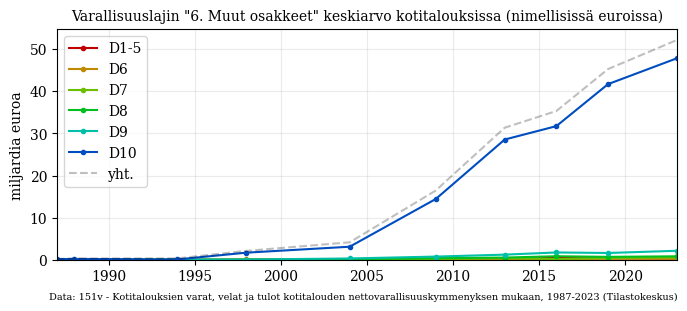

In [4]:
fig = plt.figure(figsize=(8, 3))
plot_laji(plt.gca(), "a6")
plt.show()

Karkeaa korjausta voidaan yrittää niin, että vertailukelpoiselle alueelle 2009-2023 tehdään eksponenttifunktion sovite ja ekstrapoloidaan se vertailukelvottomalle alueelle 1987-2004. Näin saadaan uusi aikasarja, jonka arvot vuodesta 2009 eteenpäin täsmäävät tilastodataan, mutta sitä ennen ovat estimaatteja. Käytännössä uuden aikasarjan ja tilastodatan erotuksesta voidaan laskea korjaustermi, joka täytyy lisätä nettovarallisuuden aikasarjaan, jotta saadaan estimaattia vastaava nettovarallisuus.

In [5]:
def estimate_correction(d, l, N=5):
    s = DATA.ftotaln()(d, l)
    s[np.isnan(s)] = 0
    p = np.polyfit(DATA.vuosi[N:], np.log(s[N:]), 1)
    t = np.concatenate([np.exp(np.polyval(p, DATA.vuosi[:N])), s[5:]])
    return t, t - s

Seuraavassa on piirretty magentalla varakkaimman kymmenyksen korjattu yhteisvarallisuus.

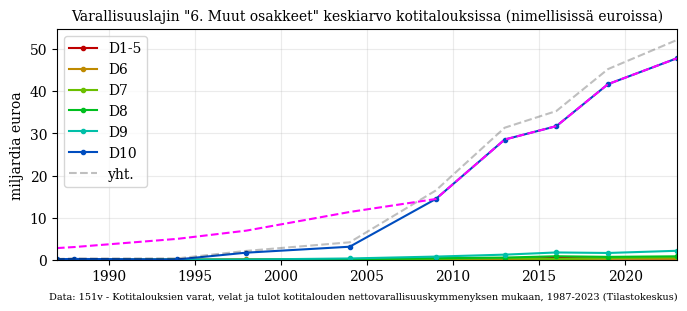

In [6]:
t, _ = estimate_correction(10, "a6", 5)

fig = plt.figure(figsize=(8, 3))
plot_laji(plt.gca(), "a6")
plt.gca().plot(DATA.vuosi, t, color="magenta", linestyle="--")
plt.show()

# Metsät, pellot ja yritysvarallisuus

Tästä varallisuuslajista puuttuvat pellot ennen vuotta 2009, ja lisäksi arvot puuttuvat ennen vuotta 1998.

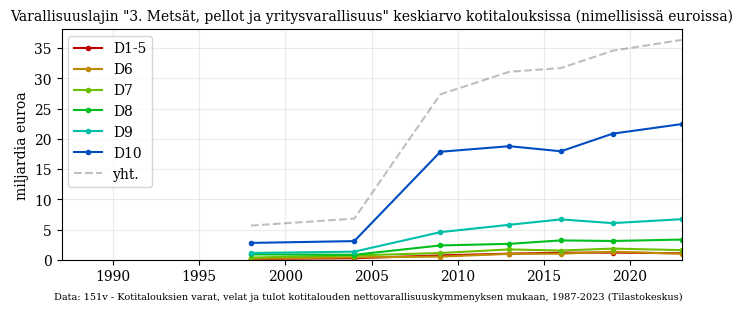

In [7]:
fig = plt.figure(figsize=(8, 3))
plot_laji(plt.gca(), "a3")
plt.show()

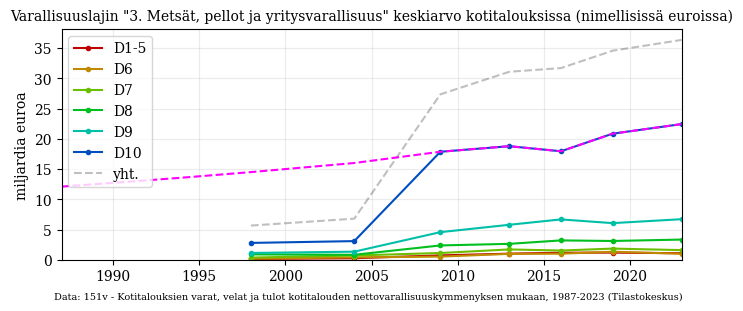

In [8]:
t, _ = estimate_correction(10, "a3", 5)

fig = plt.figure(figsize=(8, 3))
plot_laji(plt.gca(), "a3")
plt.gca().plot(DATA.vuosi, t, color="magenta", linestyle="--")
plt.show()

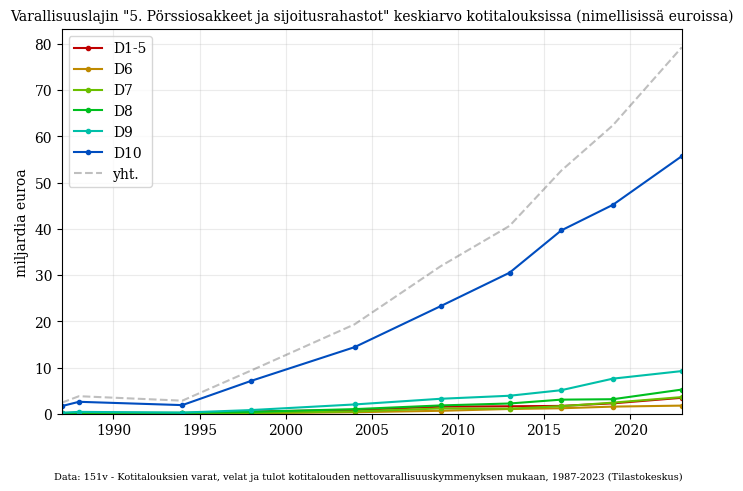

In [9]:
fig = plt.figure(figsize=(8, 5))
plot_laji(plt.gca(), "a5")
plt.savefig("a5total.png", dpi=150, bbox_inches="tight")
plt.show()

# Varallisuuserot korjattuna ja ilman

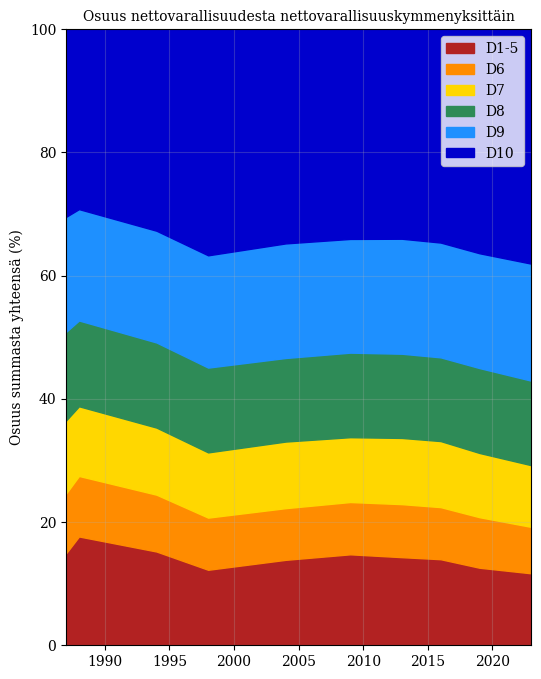

In [10]:
plt.figure(figsize=(6, 8))
local.plot.osuudet(plt.gca(), DATA, "nt", "vr", local.colors.colors6b())
plt.title("Osuus nettovarallisuudesta nettovarallisuuskymmenyksittäin")
plt.savefig("osuus.png", bbox_inches="tight", dpi=150)
plt.show()

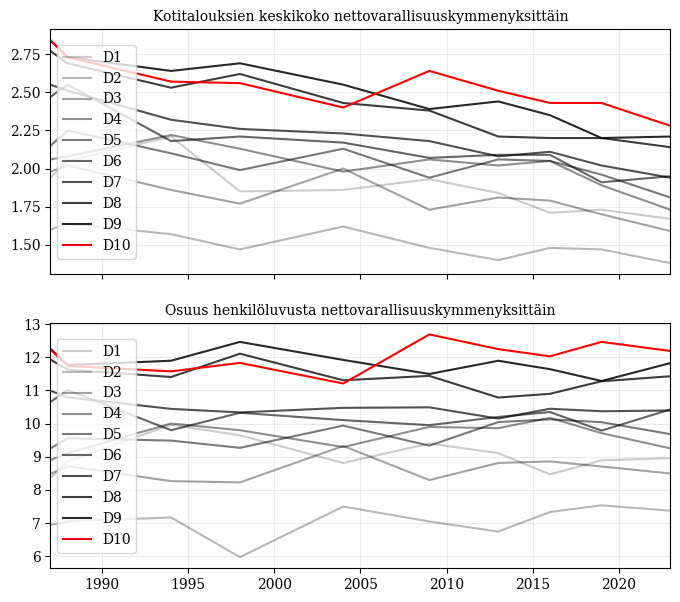

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
for d in DATA.luokat10:
    ax[0].plot(DATA.vuosi, DATA.h(d, "n", "hsz"), color=local.colors.colors10()[d], label=d)
    ax[1].plot(DATA.vuosi, DATA.hf(d, "n", "szt"), color=local.colors.colors10()[d], label=d)
ax[0].set_xlim(*DATA.vlim)
ax[0].legend(loc="center left")
ax[1].legend(loc="center left")
ax[0].set_title("Kotitalouksien keskikoko nettovarallisuuskymmenyksittäin")
ax[1].set_title("Osuus henkilöluvusta nettovarallisuuskymmenyksittäin")
plt.show()

In [12]:
def corrected_net(d):
    n = DATA.ftotaln()(d, "n")
    _, c1 = estimate_correction(d, "a6")
    _, c2 = estimate_correction(d, "a3")
    return n + c1 + c2

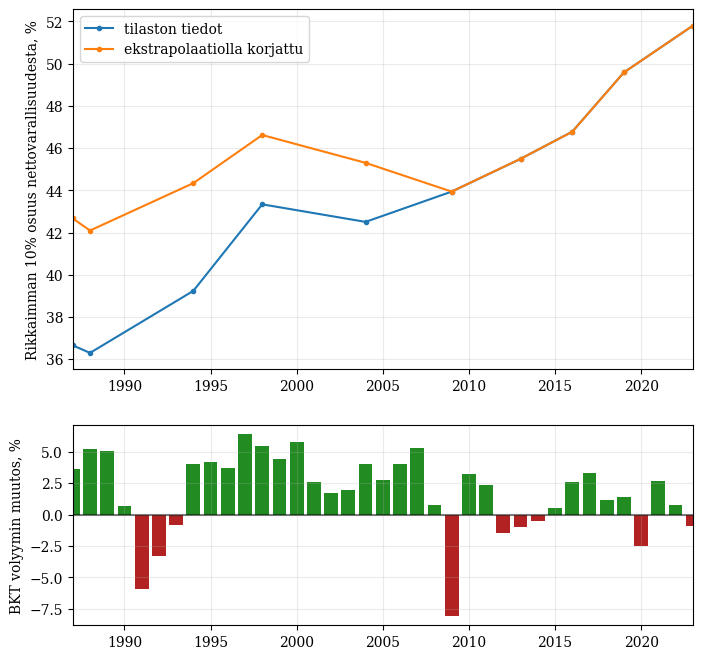

In [13]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=(1.8, 1))
ax = [fig.add_subplot(gs[0, :]), fig.add_subplot(gs[1, :])]

total = 0
for d in DATA.luokat6:
    total += corrected_net(d)

n1 = DATA.hf(10, "n")
n2 = 100 * corrected_net(10) / total
ax[0].plot(DATA.vuosi, n1, marker=".", label="tilaston tiedot")
ax[0].plot(DATA.vuosi, n2, marker=".", label="ekstrapolaatiolla korjattu")
ax[0].set_xlim(*DATA.vlim)
ax[0].set_ylabel("Rikkaimman 10% osuus nettovarallisuudesta, %")
ax[0].legend()

y = np.arange(1987, 2024)
g = [3.6, 5.2, 5.1, 0.7, -5.9, -3.3, -0.8, 4.0, 4.2, 3.7, 6.4, 5.5, 4.4, 5.8, 2.6, 1.7, 2.0, 4.0, 2.8, 4.0, 5.3, 0.8, -8.1, 3.2, 2.4, -1.5, -1.0, -0.5, 0.5, 2.6, 3.3, 1.2, 1.4, -2.5, 2.7, 0.8, -0.9]
ax[1].bar(y, g, color=["forestgreen" if v >= 0 else "firebrick" for v in g])
ax[1].axhline(0, color=(0, 0, 0, 0.5))
ax[1].set_ylabel("BKT volyymin muutos, %")
ax[1].set_xlim(*DATA.vlim)

plt.savefig("korjaus.png", dpi=150, bbox_inches="tight")
plt.show()